# Code to Train Reward Model
*Written by Luke Chang*

This notebook contains code to train the reward models. Includes feature selection, Bootstrapping, and Holdout tests

# Load Modules, Functions, and Masks

In [1]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from nltools.data import Brain_Data, Design_Matrix
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import (zscore, 
                           regress, 
                           find_spikes, 
                           one_sample_permutation, 
                           _calc_pvalue, 
                           downsample, 
                           correlation_permutation, 
                           summarize_bootstrap, 
                           threshold, 
                           fdr
                          )
from nltools.analysis import Roc
from nltools.file_reader import onsets_to_dm
from nltools.external import glover_hrf
from nltools.utils import get_anatomical
from nilearn.plotting import view_img, glass_brain, plot_stat_map, plot_anat, plot_glass_brain, plot_epi
from tqdm import tqdm
import pingouin as pg 
import re
from scipy.stats import pearsonr, spearmanr
from fnl_tools.stats import global_zscore
from fnl_tools.plotting import rec_to_time
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import GroupKFold
import plotly.express as px
from feat.plotting import plot_face, predict
from pymer4.models import Lmer, Lm, Lm2
import warnings
warnings.filterwarnings('ignore')


def forced_choice_permutation_accuracy(data1, data2, model, tail=1, n_permutations=10000, metric='correlation'):
    '''Compute one-tailed p-values for forced choice accuracy using permutation test
    
    Args:
        data1: (Brain_Data) Brain_Data instance of Condition1(must be same subject order across conditions)
        data2: (Brain_Data) Brain_Data instance of Condition2 (must be same subject order across conditions)
        model: (Brain_Data) Brain_Data instance of model to test on each condition
        n_permutations: (int) Number of permutations to run, default 5,000
        
    Returns:
        dict: Dictionary with accuracy, one-tailed p-value, and null distribution
    '''
    
    if len(data1) != len(data1):
        raise ValueError('Conditions have a different number of subjects.')
        
    pexp = pd.DataFrame({'Condition1':data1.similarity(model, method=metric), 
                         'Condition2':data2.similarity(model, method=metric)})

    accuracy = np.mean(pexp['Condition1'] > pexp['Condition2'])

    null = []
    for iteration in range(n_permutations):
        null_iteration = []
        for i in range(len(pexp)):
            choice = np.random.choice([0,1])
            null_iteration.append(pexp.iloc[i, choice] > pexp.iloc[i, 1-choice])
        null.append(np.mean(null_iteration))

    return {'accuracy':accuracy, 'p':_calc_pvalue(null, accuracy, tail), 'null':null, 'pattern_similarity':pexp}


def plot_forced_choice_accuracy(data, line_color='lightgrey', line_width=2, line_style='-',
                                condition1_color='skyblue', condition2_color='navy',
                                point_size=8, labels=True, label_size=12, label_color='black',
                                ref_line=False, ref_line_style='--', ref_line_color='lightgrey',
                                text_gap=.005, vertical_gap=1, height_ratio=5, width_ratio=1.5):
    ''' Create a plot showing forced choice accuracy for each subject
    
    Args:
        line_color: (str) color of connecting line
        line_width: (int) width of connecting line
        line_style: (str) style of connecting line
        condition1_color: (str) color of marker for condition1
        condition2_color: (str) color of marker for condition2
        point_size: (int) size of marker
        labels: (bool) plot index as label
        label_size: (int) font size for label
        label_color: (str) font color for label
        ref_line: (bool) plot a reference line at x=0
        ref_line_style: (str) style for reference line
        ref_line_color: (str) color for reference line
        text_gap: (float) offset of text from point
        height_ratio: (float) scales figure height (i.e., distance between lines)
        width_ratio: (float) scales width of figure relative to height
        
    Returns:
        matplotlib object
    
    '''
    data.sort_values('Condition1', ascending=True, inplace=True)

    f,a = plt.subplots(figsize=(height_ratio*width_ratio, int(len(data)/height_ratio)))
    
    if ref_line:
        plt.axvline(0, linestyle=ref_line_style, color=ref_line_color)
    
    for i, idx in enumerate(data.iterrows()):
        row = idx[1]
        height = i/(len(data)/height_ratio)
#         height = ((i+)/((len(data)+1)/height_ratio))
        
        a.plot(row['Condition1'], height, color=condition1_color, marker='o', markersize=point_size)
        a.plot(row['Condition2'], height, color=condition2_color, marker='o', markersize=point_size)
        a.hlines(y=height, color=line_color, linestyle=line_style, linewidth=line_width,
                 xmax=max(row['Condition1'], row['Condition2']), 
                 xmin=min(row['Condition1'], row['Condition2']))
        
        if labels:
            a.annotate(int(row['Label']), xy=(min(row['Condition1'], row['Condition2'])-text_gap, height), 
                       horizontalalignment='right', verticalalignment='center',
                       size=label_size, color=label_color)
    
    a.get_yaxis().set_visible(False)
    a.set_xlim((min(data['Condition1'].min(), data['Condition2'].min() - text_gap - .05),
               max(data['Condition1'].max(), data['Condition2'].max() + text_gap + .05)))
    plt.tight_layout()
    
def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    l.sort( key=alphanum_key )


zscore = lambda x: (x - np.mean(x, axis=0)) / np.std(x, axis=0)
center = lambda x: (x - np.mean(x, axis=0))

# Location of data
data_dir = '/Storage/Projects/Reward_Model'
hcp_dir = '/Storage/Data/HCP'

# Load Masks
mask = Brain_Data(os.path.join(data_dir, 'Masks', 'k50_2mm.nii.gz'))
mask_x = expand_mask(mask)

neurosynth_reward = Brain_Data(os.path.join(data_dir, 'Masks', 'reward_association-test_z_FDR_0.01.nii.gz'))
reward_mask = neurosynth_reward.smooth(5).threshold(upper=3.5, binarize=True)


/home/ljchang/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/ljchang/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Train HCP Reward Model

Train whole brain model to discriminate between reward and punishment in HCP data using delgado card task. 

## Create Hold out test data set (only need to run once).
Leave 20% of data out for final hold out.

In [2]:
hcp_reward = Brain_Data(os.path.join(hcp_dir, 'Analyses','HCP_GAMBLING', 'HCP_GAMBLING_Reward_n490.hdf5'))
hcp_punish = Brain_Data(os.path.join(hcp_dir, 'Analyses','HCP_GAMBLING', 'HCP_GAMBLING_Punish_n490.hdf5'))

n = int(len(hcp_reward)*.2)
test_idx = np.random.choice(range(len(hcp_reward)), size=n, replace=False)
holdout_index = pd.Series(['Train']*len(hcp_reward))
holdout_index[test_idx] = 'Test'
holdout_index.to_csv(os.path.join(hcp_dir, 'Analyses','HCP_GAMBLING', 'HCP_GAMBLING_test_subjects.csv'), index=False)

hcp_reward_test = hcp_reward[holdout_index=='Test']
hcp_reward_test.write(os.path.join(hcp_dir, 'Analyses','HCP_GAMBLING', f'HCP_GAMBLING_Reward_Test_n{len(hcp_reward_test)}.hdf5'))
hcp_reward_train = hcp_reward[holdout_index=='Train']
hcp_reward_train.write(os.path.join(hcp_dir, 'Analyses','HCP_GAMBLING', f'HCP_GAMBLING_Reward_Train_n{len(hcp_reward_train)}.hdf5'))
hcp_punish_test = hcp_punish[holdout_index=='Test']
hcp_punish_test.write(os.path.join(hcp_dir, 'Analyses','HCP_GAMBLING', f'HCP_GAMBLING_Punish_Test_n{len(hcp_punish_test)}.hdf5'))
hcp_punish_train = hcp_punish[holdout_index=='Train']
hcp_punish_train.write(os.path.join(hcp_dir, 'Analyses','HCP_GAMBLING', f'HCP_GAMBLING_Punish_Train_n{len(hcp_punish_train)}.hdf5'))


/home/ljchang/anaconda3/lib/python3.8/site-packages/deepdish/io/hdf5io.py:251: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


## Train Model 
- Remove Subject mean across conditions
- z-scoring within each image
- no smoothing 

In [8]:
smooth = 0

# Load Data
hcp_reward = Brain_Data(os.path.join(hcp_dir, 'Analyses','HCP_GAMBLING', 'HCP_GAMBLING_Reward_Train_n392.hdf5'))
hcp_punish = Brain_Data(os.path.join(hcp_dir, 'Analyses','HCP_GAMBLING', 'HCP_GAMBLING_Punish_Train_n392.hdf5'))

hcp_mean = (hcp_reward + hcp_punish)/2
hcp_reward = hcp_reward - hcp_mean
hcp_punish = hcp_punish - hcp_mean

data = hcp_reward.append(hcp_punish)
data.Y = pd.Series(list(np.ones(len(hcp_reward))) + list(np.zeros(len(hcp_punish))))
subject_id = [x for x in range(len(hcp_reward))]*2

svm_stats = data.standardize(axis=1).predict(algorithm='svm', cv_dict={'type': 'kfolds','n_folds': 5, 'subject_id':subject_id}, **{'class_weight':'balanced', 'kernel':"linear"})

# Write out weight map
svm_stats['weight_map'].write(os.path.join(data_dir, 'Analyses', 'Classification', f'SVM_HCP_Reward_vs_Punish_n{len(hcp_punish)}_demeaned_zscore1_smooth{smooth}_weightmap.nii.gz'))

# Write out cross-validation info
svm_stats['weight_map_xval'].write(os.path.join(data_dir, 'Analyses', 'Classification', f'SVM_HCP_Reward_vs_Punish_n{len(hcp_punish)}_demeaned_zscore1_smooth{smooth}_weightmap_xval.nii.gz'))
xval = pd.DataFrame({'Subject':[x for x in range(0,len(hcp_reward)*2)]})
for i in range(5):
    xval[f'Train_{i}'] = 0
    xval.loc[svm_stats['cv_idx'][i][0], f'Train_{i}'] = 1
xval.to_csv(os.path.join(data_dir, 'Analyses', 'Classification', f'SVM_HCP_Reward_vs_Punish_demeaned_zscore1_smooth{smooth}_xval_split.csv'), index=False)

print(f"Forced Choice Accuracy: {np.mean(svm_stats['yfit_xval'][:len(hcp_reward)] > svm_stats['yfit_xval'][len(hcp_reward):]):.02}")


/home/ljchang/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


overall accuracy: 1.00
overall CV accuracy: 0.98
Forced Choice Accuracy: 0.98


In [391]:
roc = Roc(input_values=svm_stats['Y']==1, binary_outcome=svm_stats['yfit_xval']==1)
roc.calculate()
roc.summary()

------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.98
Accuracy SE:        0.03
Accuracy p-value:   0.00
Sensitivity:        0.98
Specificity:        0.98
AUC:                0.98
PPV:                0.98
------------------------


### Make ROC Plot

In [99]:
smooth = 0

# Load Data
hcp_reward_train = Brain_Data(os.path.join(hcp_dir, 'Analyses','HCP_GAMBLING', 'HCP_GAMBLING_Reward_Train_n392.hdf5'))
hcp_punish_train = Brain_Data(os.path.join(hcp_dir, 'Analyses','HCP_GAMBLING', 'HCP_GAMBLING_Punish_Train_n392.hdf5'))

hcp_mean = (hcp_reward_train + hcp_punish_train)/2
hcp_reward_train = hcp_reward_train - hcp_mean
hcp_punish_train = hcp_punish_train - hcp_mean

data = hcp_reward_train.append(hcp_punish_train)
data.Y = pd.Series(list(np.ones(len(hcp_reward_train))) + list(np.zeros(len(hcp_punish_train))))
subject_id = [x for x in range(len(hcp_reward_train))]*2

weight_map_xval = Brain_Data(os.path.join(data_dir, 'Analyses', 'Classification', f'SVM_HCP_Reward_vs_Punish_n{len(hcp_punish_train)}_demeaned_zscore1_smooth{smooth}_weightmap_xval.nii.gz'))

hcp_reward_test = Brain_Data(os.path.join(hcp_dir, 'Analyses','HCP_GAMBLING', 'HCP_GAMBLING_Reward_Test_n98.hdf5'))
hcp_punish_test = Brain_Data(os.path.join(hcp_dir, 'Analyses','HCP_GAMBLING', 'HCP_GAMBLING_Punish_Test_n98.hdf5'))

xval_idx = pd.read_csv(os.path.join(data_dir, 'Analyses', 'Classification', f'SVM_HCP_Reward_vs_Punish_demeaned_zscore1_smooth{smooth}_xval_split.csv'))
xval_idx['Subject'] = [x for x in range(len(hcp_reward_train))]*2
xval_idx['Y'] = np.hstack([np.ones(len(hcp_reward_train)), np.zeros(len(hcp_punish_train))])
all_xval_data = []
for i in range(5):
    sub_xval = xval_idx[xval_idx.iloc[:,1+i]==0]
    sub_xval['Similarity'] = data[xval_idx.iloc[:,1+i]==0].similarity(weight_map_xval[i])
    all_xval_data.append(sub_xval)
all_xval_data = pd.concat(all_xval_data)
all_xval_data.reset_index(inplace=True, drop=True)

# for i in range(5):
#     xval_dat = data[xval_idx.iloc[:,1+i]==0].similarity(weight_map_xval[i])
#     n_sub = int(len(xval_dat)/2)
#     fc_xval.append((np.sum((xval_dat[:n_sub] - xval_dat[n_sub:]) > 0)/n_sub))
# print(fc_xval)
# print(f'Cross-Validated Accuracy: {np.mean(fc_xval):.02}')
# print(f'Hold-Out Accuracy: {np.mean((hcp_reward_test.similarity(reward_model) - hcp_punish_test.similarity(reward_model)) > 0):.02}')


<ipython-input-99-f73fc6d3dfa5>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_xval['Similarity'] = data[xval_idx.iloc[:,1+i]==0].similarity(weight_map_xval[i])
<ipython-input-99-f73fc6d3dfa5>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_xval['Similarity'] = data[xval_idx.iloc[:,1+i]==0].similarity(weight_map_xval[i])
<ipython-input-99-f73fc6d3dfa5>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

#### Cross-validated ROC Curve

------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.98
Accuracy SE:        0.05
Accuracy p-value:   0.00
Sensitivity:        0.97
Specificity:        0.97
AUC:                0.97
PPV:                0.97
------------------------


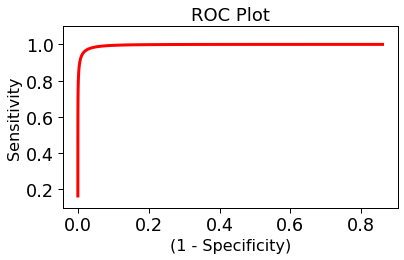

In [129]:
with sns.plotting_context(context='paper', font_scale=2):
    roc = Roc(input_values=np.array(all_xval_data['Similarity']),
          binary_outcome=np.array(all_xval_data['Y']==1),
          forced_choice=np.array(all_xval_data['Subject']))
    roc.plot()
    ax = plt.gca()
    ax.set_ylim([0.1,1.1])
    plt.tight_layout()
    plt.savefig(os.path.join(data_dir, 'Figures', f'ROC_Plot_CrossValidated_{analysis_name}.png'), dpi=300)
    plt.savefig(os.path.join(data_dir, 'Figures', f'ROC_Plot_CrossValidated_{analysis_name}.pdf'))
roc.summary()


#### Hold Out test ROC Curve

------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.99
Accuracy SE:        0.10
Accuracy p-value:   0.00
Sensitivity:        0.99
Specificity:        0.99
AUC:                0.99
PPV:                0.99
------------------------


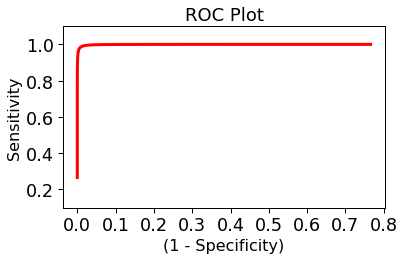

In [130]:
with sns.plotting_context(context='paper', font_scale=2):
    roc = Roc(input_values = np.hstack([hcp_reward_test.similarity(reward_model),hcp_punish_test.similarity(reward_model)]),
        binary_outcome=np.hstack([np.ones(len(hcp_reward_test)), np.zeros(len(hcp_punish_test))])==1,
        forced_choice=np.array([x for x in range(len(hcp_reward_test))]*2))
    roc.plot()
    ax = plt.gca()
    ax.set_ylim([0.1,1.1])
    plt.tight_layout()
    plt.savefig(os.path.join(data_dir, 'Figures', f'ROC_Plot_Holdout_Test_{analysis_name}.png'), dpi=300)
    plt.savefig(os.path.join(data_dir, 'Figures', f'ROC_Plot_Holdout_Test_{analysis_name}.pdf'))
roc.summary()

## Train Model after using Neurosynth Reward Mask, Remove Subject mean across conditions, Z-Scoring, No Smoothing


In [10]:
smooth = 0

# Load Data
hcp_reward = Brain_Data(os.path.join(hcp_dir, 'Analyses','HCP_GAMBLING', 'HCP_GAMBLING_Reward_Train_n392.hdf5'))
hcp_punish = Brain_Data(os.path.join(hcp_dir, 'Analyses','HCP_GAMBLING', 'HCP_GAMBLING_Punish_Train_n392.hdf5'))

hcp_mean = (hcp_reward + hcp_punish)/2
hcp_reward = hcp_reward - hcp_mean
hcp_punish = hcp_punish - hcp_mean

data = hcp_reward.append(hcp_punish)
data = data
data.Y = pd.Series(list(np.ones(len(hcp_reward))) + list(np.zeros(len(hcp_punish))))
subject_id = [x for x in range(len(hcp_reward))]*2

svm_stats = data.apply_mask(reward_mask).standardize(axis=1).predict(algorithm='svm', cv_dict={'type': 'kfolds','n_folds': 5, 'subject_id':subject_id}, **{'class_weight':'balanced', 'kernel':"linear"})

# Write out weight map
svm_stats['weight_map'].write(os.path.join(data_dir, 'Analyses', 'Classification', f'SVM_HCP_Reward_vs_Punish_n{len(hcp_punish)}_masked_demeaned_zscore1_smooth{smooth}_weightmap.nii.gz'))

# Write out cross-validation info
svm_stats['weight_map_xval'].write(os.path.join(data_dir, 'Analyses', 'Classification', f'SVM_HCP_Reward_vs_Punish_n{len(hcp_punish)}_masked_demeaned_zscore1_smooth{smooth}_weightmap_xval.nii.gz'))
xval = pd.DataFrame({'Subject':[x for x in range(0,len(hcp_reward)*2)]})
for i in range(5):
    xval[f'Train_{i}'] = 0
    xval.loc[svm_stats['cv_idx'][i][0], f'Train_{i}'] = 1
xval.to_csv(os.path.join(data_dir, 'Analyses', 'Classification', f'SVM_HCP_Reward_vs_Punish_masked_demeaned_zscore1_smooth{smooth}_xval_split.csv'), index=False)

print(f"Forced Choice Accuracy: {np.mean(svm_stats['yfit_xval'][:len(hcp_reward)] > svm_stats['yfit_xval'][len(hcp_reward):]):.02}")


/home/ljchang/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


overall accuracy: 1.00
overall CV accuracy: 0.81
Forced Choice Accuracy: 0.81


In [452]:
roc = Roc(input_values=svm_stats['Y'], binary_outcome=svm_stats['yfit_xval']>0, forced_choice=np.array([x for x in range(0,490)]*2))
roc.calculate()
roc.summary()

------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.65
Accuracy SE:        0.03
Accuracy p-value:   0.00
Sensitivity:        0.83
Specificity:        0.83
AUC:                0.07
PPV:                0.83
------------------------


# Bootstrap Reward Model
- Retrain model resampling training data with replacement. 
- Identify voxels that consistently have the same sign across bootstrap samples. 
- Very computationally expensive - takes several days and lots of RAM

In [3]:
smooth = 0

hcp_reward = Brain_Data(os.path.join(hcp_dir, 'Analyses','HCP_GAMBLING', 'HCP_GAMBLING_Reward_Train_n392.hdf5'))
hcp_punish = Brain_Data(os.path.join(hcp_dir, 'Analyses','HCP_GAMBLING', 'HCP_GAMBLING_Punish_Train_n392.hdf5'))

hcp_mean = (hcp_reward + hcp_punish)/2
hcp_reward = hcp_reward - hcp_mean
hcp_punish = hcp_punish - hcp_mean

data = hcp_reward.append(hcp_punish)
data.Y = pd.Series(list(np.ones(len(hcp_reward))) + list(np.zeros(len(hcp_punish))))
subject_id = [x for x in range(len(hcp_reward))]*2

data = data.standardize(axis=1)

b = data.bootstrap('predict', n_samples=5000, algorithm='svm', save_weights=True, kernel="linear", n_jobs=16)

b['samples'].write(os.path.join(data_dir, 'Analyses', 'Classification', f'Reward_Model_Bootstrap_{analysis_name}_n5000.hdf5'))


/home/ljchang/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/ljchang/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/ljchang/anaconda3/lib/python3.8/site-packages/deepdish/io/hdf5io.py:251: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


## Create bootstrap thresholded weight map

FDR Threshold: 0.000295103131904062


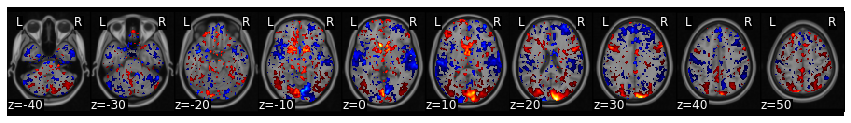

In [18]:
bootstrap = Brain_Data(os.path.join(data_dir, 'Analyses', 'Classification', f'Reward_Model_Bootstrap_{analysis_name}_n5000.hdf5'))
bootstrap_summary = summarize_bootstrap(bootstrap)

bootstrap_summary['Z'].write(os.path.join(data_dir, 'Analyses', 'Classification', f'SVM_HCP_Reward_vs_Punish_n392_demeaned_zscore1_smooth0_bootstrap_5000_Z.nii.gz'))
bootstrap_summary['p'].write(os.path.join(data_dir, 'Analyses', 'Classification', f'SVM_HCP_Reward_vs_Punish_n392_demeaned_zscore1_smooth0_bootstrap_5000_p.nii.gz'))

thresh = fdr(bootstrap_summary['p'].data, q=0.001)
print(f'FDR Threshold: {thresh}')
reward_model_thresholded = threshold(reward_model, bootstrap_summary['p'], thr=thresh)
reward_model_thresholded.write(os.path.join(data_dir, 'Analyses', 'Classification', f'SVM_HCP_Reward_vs_Punish_n392_demeaned_zscore1_smooth0_bootstrap_5000_thresholded_weightmap_fdr_001.nii.gz'))

reward_model_thresholded.plot()

In [30]:
bootstrap_summary['Z'].iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

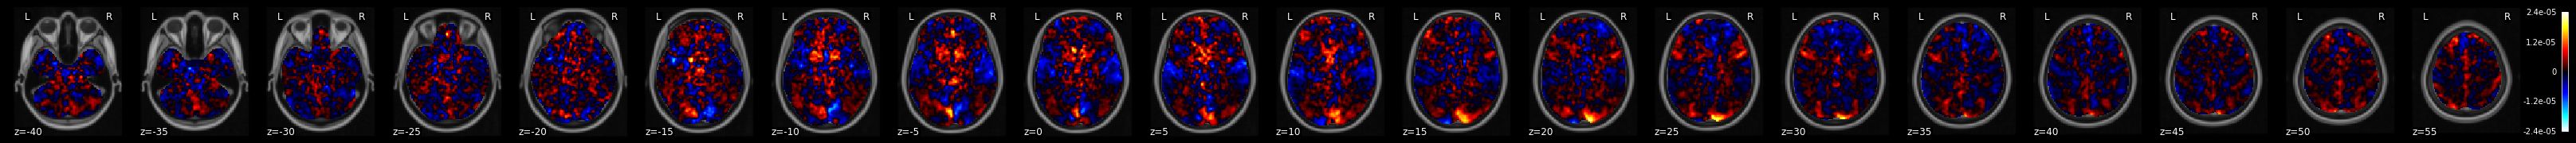

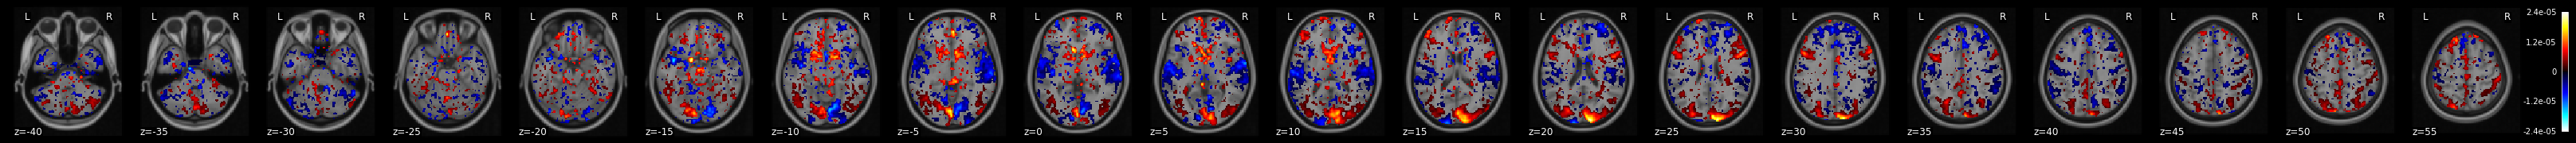

In [63]:
plot_stat_map(reward_model.to_nifti(), get_anatomical(),
              cut_coords=range(-40, 60, 5), 
              black_bg=True, display_mode='z', 
              draw_cross=False, 
              colorbar=True, 
              threshold=0)
plt.savefig(os.path.join(data_dir, 'Figures', f'Reward_Model_{analysis_name}_Weightmap_Axial.png'), dpi=300)

plot_stat_map(reward_model_thresholded.to_nifti(), get_anatomical(),
              cut_coords=range(-40, 60, 5), 
              black_bg=True, display_mode='z', 
              draw_cross=False, 
              colorbar=True, 
              threshold=0)
plt.savefig(os.path.join(data_dir, 'Figures', f'Reward_Model_{analysis_name}_Weightmap_fdr_thresholded_Axial.png'), dpi=300)

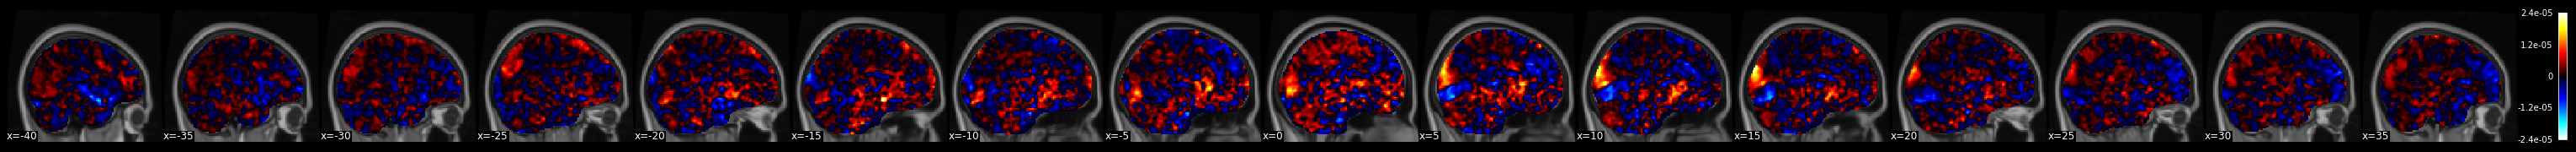

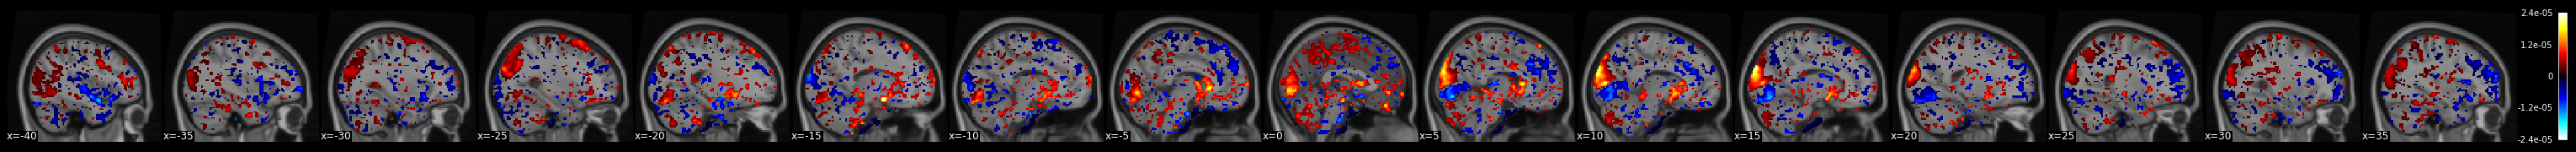

In [64]:
plot_stat_map(reward_model.to_nifti(), get_anatomical(),
              cut_coords=range(-40, 40, 5), 
              black_bg=True, display_mode='x', 
              draw_cross=False, 
              colorbar=True, 
              threshold=0)
plt.savefig(os.path.join(data_dir, 'Figures', f'Reward_Model_{analysis_name}_Weightmap_Sagittal.png'), dpi=300)

plot_stat_map(reward_model_thresholded.to_nifti(), get_anatomical(),
              cut_coords=range(-40, 40, 5), 
              black_bg=True, display_mode='x', 
              draw_cross=False, 
              colorbar=True, 
              threshold=0)
plt.savefig(os.path.join(data_dir, 'Figures', f'Reward_Model_{analysis_name}_Weightmap_fdr_thresholded_Sagittal.png'), dpi=300)

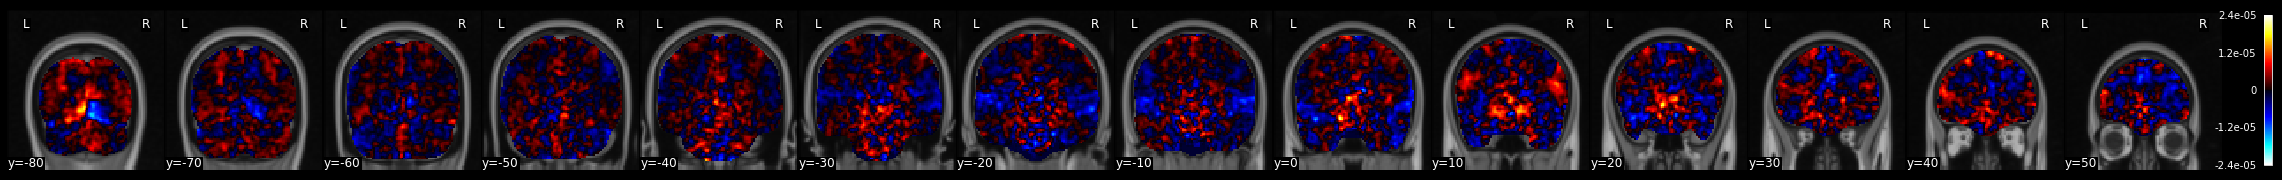

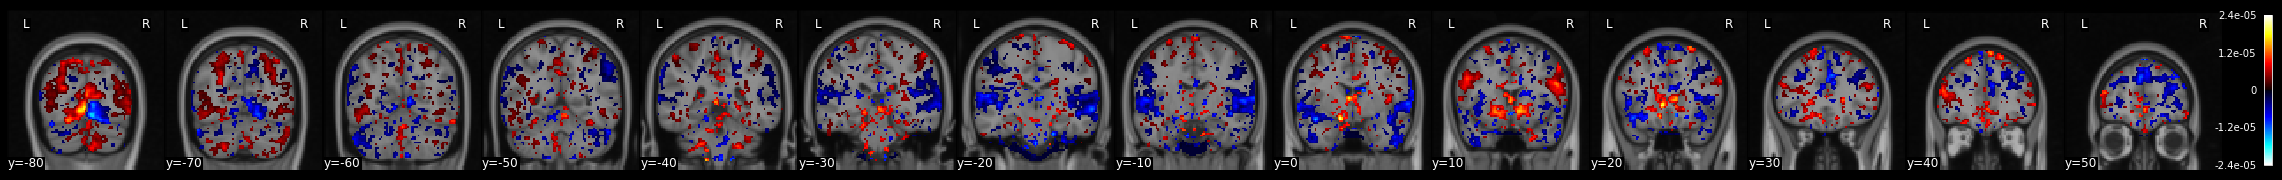

In [67]:
plot_stat_map(reward_model.to_nifti(), get_anatomical(),
              cut_coords=range(-80, 60, 10), 
              black_bg=True, display_mode='y', 
              draw_cross=False, 
              colorbar=True, 
              threshold=0)
plt.savefig(os.path.join(data_dir, 'Figures', f'Reward_Model_{analysis_name}_Weightmap_Coronal.png'), dpi=300)

plot_stat_map(reward_model_thresholded.to_nifti(), get_anatomical(),
              cut_coords=range(-80, 60, 10), 
              black_bg=True, display_mode='y', 
              draw_cross=False, 
              colorbar=True, 
              threshold=0)
plt.savefig(os.path.join(data_dir, 'Figures', f'Reward_Model_{analysis_name}_Weightmap_fdr_thresholded_Coronal.png'), dpi=300)

## Compute Spatial ISC across bootstraps

In [22]:
sim = 1 - bootstrap.distance(metric='correlation', n_jobs=20)
sim.write(os.path.join(data_dir, 'Analyses', 'Classification', f'bootstrap_similarity_adjacency.hdf5'))

spatial_isc = sim.isc(metric='mean')

spatial_isc

In [28]:
spatial_isc

{'isc': 0.9256086226877123,
 'p': 0.0001999600079984003,
 'ci': (0.9257668689116438, 0.9257668689116438)}

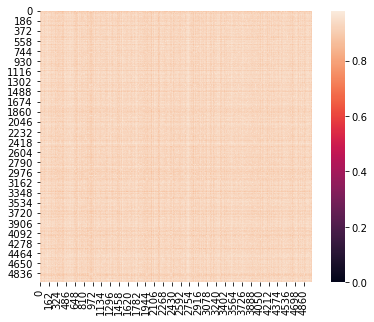

In [29]:
sim.plot()

# Plot Forced Choice Accuracy on HCP Gambling Test

In [163]:
hcp_reward_test = Brain_Data(os.path.join(hcp_dir, 'Analyses','HCP_GAMBLING', 'HCP_GAMBLING_Reward_Test_n98.hdf5'))
hcp_punish_test = Brain_Data(os.path.join(hcp_dir, 'Analyses','HCP_GAMBLING', 'HCP_GAMBLING_Punish_Test_n98.hdf5'))

output_hcp_gambling = forced_choice_permutation_accuracy(hcp_reward_test, hcp_punish_test, reward_model)
print(f"Forced Choice Accuracy={output_hcp_gambling['accuracy']:.02}, p = {output_hcp_gambling['p']:.03}")


Forced Choice Accuracy=0.99, p = 0.0001


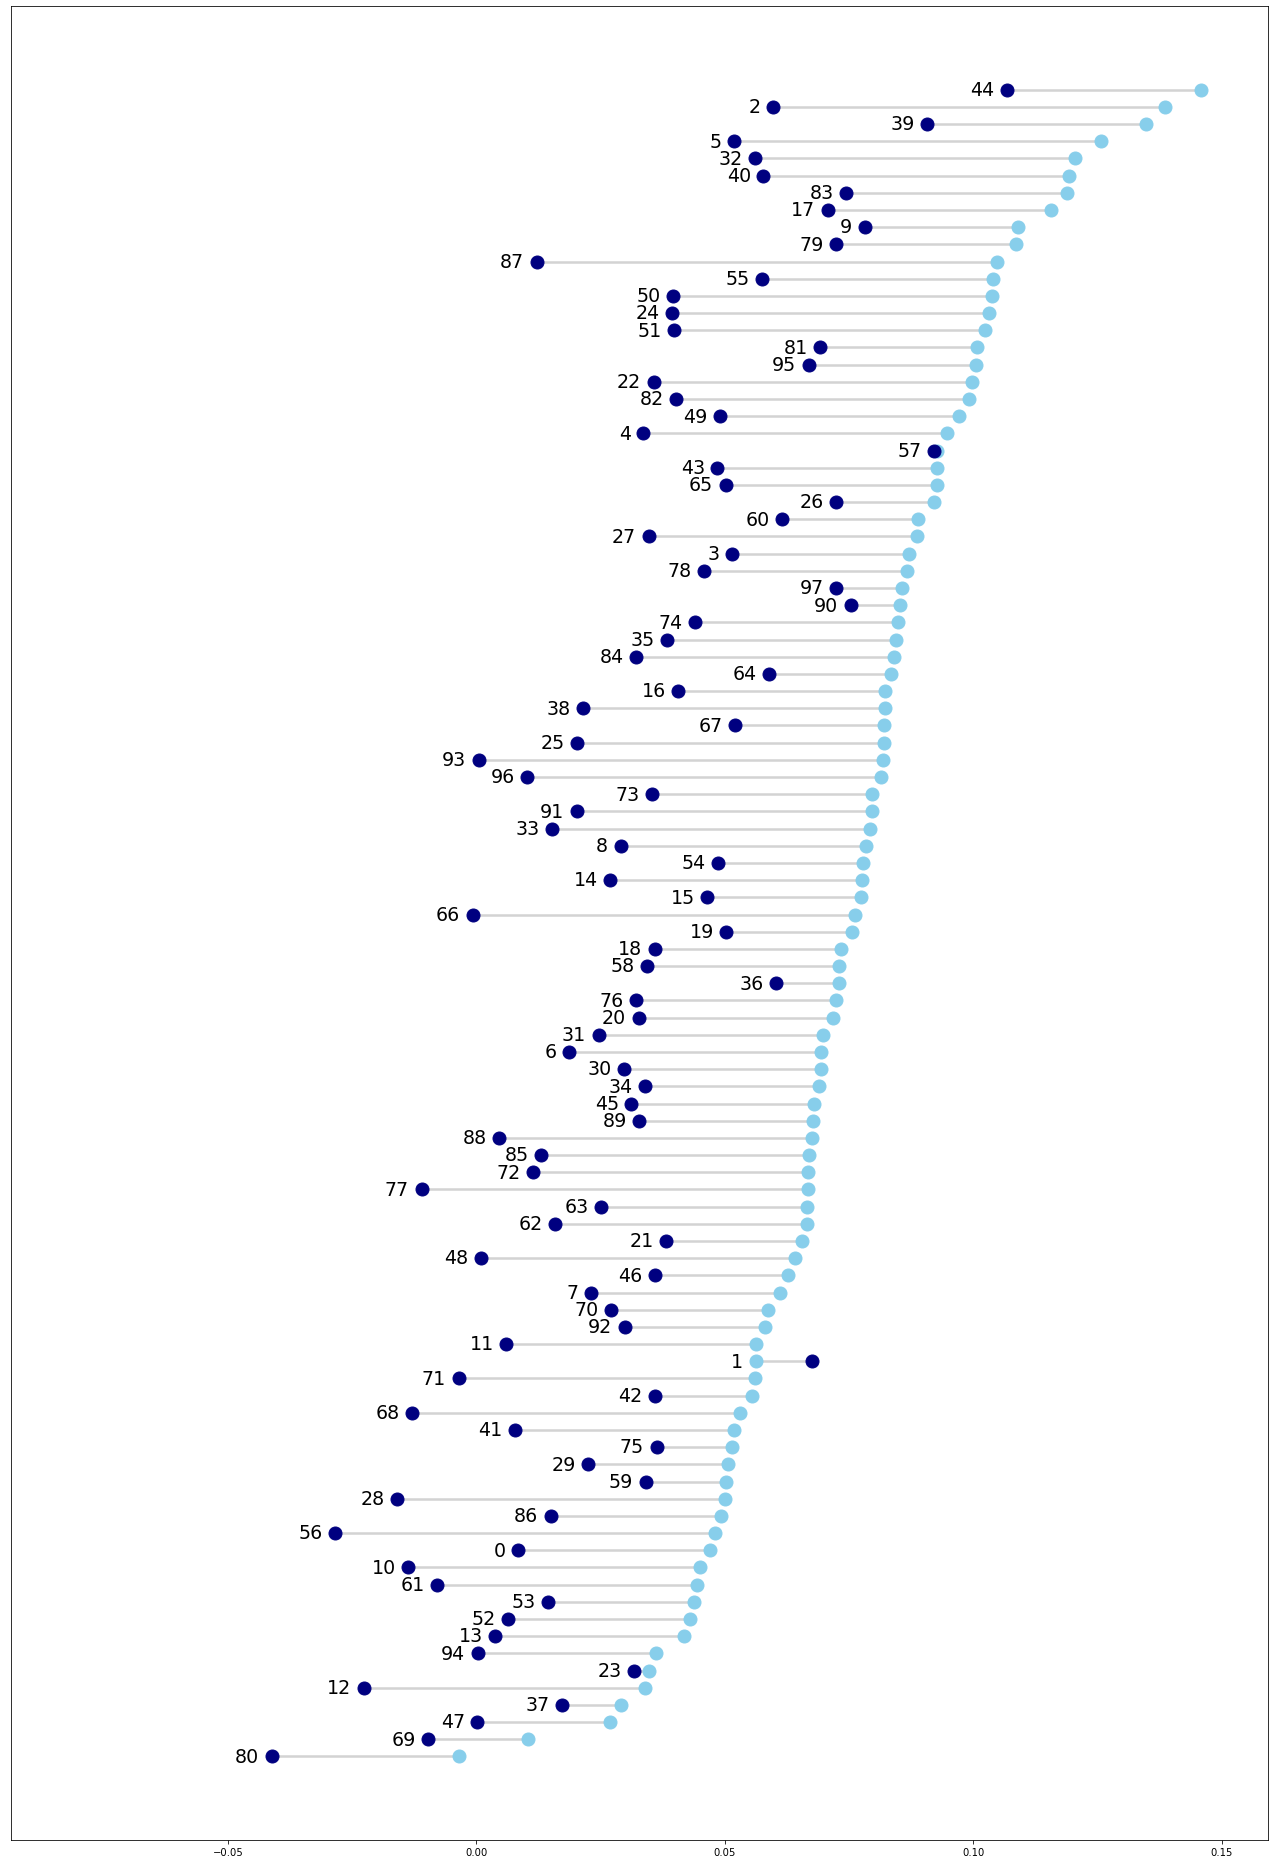

In [135]:

dat = pd.DataFrame({'Condition1':hcp_reward_test.similarity(reward_model, method='correlation'), 
                    'Condition2':hcp_punish_test.similarity(reward_model, method='correlation')})
dat['Label'] = dat.index
dat['Label'] = dat['Label'].astype(int)
                    
plot_forced_choice_accuracy(dat, label_size=19, point_size=13, text_gap=.0025, 
                            line_width=2.5, width_ratio=4.75, height_ratio=3.75)
                    
plt.savefig(os.path.join(data_dir, 'Figures', f'Forced_Choice_Accuracy_{analysis_name}.png'), dpi=300)
plt.savefig(os.path.join(data_dir, 'Figures', f'Forced_Choice_Accuracy_{analysis_name}.pdf'))


# Plot Maps
Load masks and models. Models can obviously only be loaded after they have been trained

In [2]:
analysis_name = 'demeaned_zscore1_smooth0'

reward_model = Brain_Data(os.path.join(data_dir, 'Analyses', 'Classification', f'SVM_HCP_Reward_vs_Punish_n392_{analysis_name}_weightmap.nii.gz'))
reward_model_masked = Brain_Data(os.path.join(data_dir, 'Analyses', 'Classification', f'SVM_HCP_Reward_vs_Punish_n392_masked_{analysis_name}_weightmap.nii.gz'))


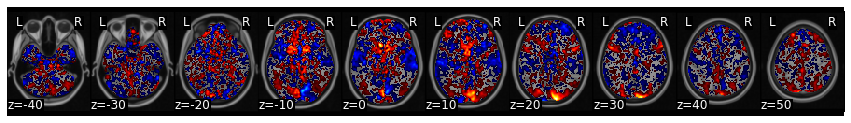

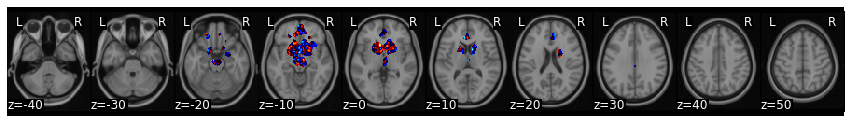

In [45]:
reward_model.plot()
reward_model_masked.plot()